In [2]:
import maboss
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os

ipylab module is not installed, menus and toolbar are disabled.


In [3]:
model_file = "../maboss/models/model_one.bnd"
cfg_file = "../maboss/models/model_one_base.cfg"
model = maboss.load(model_file, cfg_file)

In [4]:
""" Function to get phenotypes from RhoA / RhoC Combinations. """

def get_phenotypes(prob):
    cols_only_A = prob.filter(regex='RhoA').columns.difference(prob.filter(regex='RhoC').columns)
    rhoA_df = prob[cols_only_A].sum(axis=1)
    

    cols_only_C = prob.filter(regex='RhoC').columns.difference(prob.filter(regex='RhoA').columns)
    rhoC_df = prob[cols_only_C].sum(axis=1)
    

    cols_both_AC = prob.filter(regex='RhoA').filter(regex='RhoC').columns
    both_df = prob[cols_both_AC].sum(axis=1)

    result_df = pd.DataFrame({
        'Failed': rhoA_df,
        'Hyper': rhoC_df,
        'Normal': both_df
    })
    return result_df

In [5]:
""" Create KO / Perturtbations """

from itertools import combinations

nodes = ['DSP', 'TJP1', 'JCAD']
ko_scenarios = {'WT': {"model": model, "ko_combo": () }}

for r in range (1, len(nodes)+1):
    for combo in combinations(nodes, r):
        name = '_'.join(combo)
        #print(f"name: {name} for combo {combo}")
        m = model.copy()
        for n in combo:
            m.mutate(n, "OFF")
            m.update_parameters(**{f"${n}_base": 0.0})
        ko_scenarios[name] = {"model": m, "ko_combo": combo}
ko_scenarios

{'WT': {'model': <maboss.simulation.Simulation at 0x2873eed50>,
  'ko_combo': ()},
 'DSP': {'model': <maboss.simulation.Simulation at 0x132667b50>,
  'ko_combo': ('DSP',)},
 'TJP1': {'model': <maboss.simulation.Simulation at 0x28740fa50>,
  'ko_combo': ('TJP1',)},
 'JCAD': {'model': <maboss.simulation.Simulation at 0x28740d290>,
  'ko_combo': ('JCAD',)},
 'DSP_TJP1': {'model': <maboss.simulation.Simulation at 0x132699610>,
  'ko_combo': ('DSP', 'TJP1')},
 'DSP_JCAD': {'model': <maboss.simulation.Simulation at 0x132698110>,
  'ko_combo': ('DSP', 'JCAD')},
 'TJP1_JCAD': {'model': <maboss.simulation.Simulation at 0x28732d9d0>,
  'ko_combo': ('TJP1', 'JCAD')},
 'DSP_TJP1_JCAD': {'model': <maboss.simulation.Simulation at 0x28732f6d0>,
  'ko_combo': ('DSP', 'TJP1', 'JCAD')}}

In [16]:
results_dir = "../results/model_one"
os.makedirs(results_dir, exist_ok=True)
perbs_summary = []

for name, info in ko_scenarios.items():
    m = info["model"]

    res = m.run() # Run simulation

    # --- Phenotype summary ---
    prob = res.get_states_probtraj()

    pheno = get_phenotypes(prob)   # Map states to phenotypes
    final = pheno.iloc[-1]         # Take final time point

    perbs_summary.append({'cond': name, **final.to_dict()})

    # --- Save detailed trajectories ---
    scenario_dir = os.path.join(results_dir, name)
    os.makedirs(scenario_dir, exist_ok=True)

    # Save state probability trajectory
    prob.to_csv(os.path.join(scenario_dir, f"{name}_probtraj.csv"))
    
    # Save node probabilities
    nodes = res.get_nodes_probtraj()
    nodes.to_csv(os.path.join(scenario_dir, f"{name}_nodes_probtraj.csv"))
    
    # Optional: save the full simulation object
    res.save(os.path.join(scenario_dir, f"{name}_simulation"))
    
    res.plot_node_trajectory()
    fig = plt.gcf()
    plt.savefig(os.path.join(scenario_dir, f"{name}_node_trajectories.png"))
    plt.close() 

    # plt.savefig(os.path.join(scenario_dir, f"{name}_node_trajectories.png"))
    # plt.close() 


Error directory already exists: ../results/model_one/WT/WT_simulation
Error directory already exists: ../results/model_one/DSP/DSP_simulation
Error directory already exists: ../results/model_one/TJP1/TJP1_simulation
Error directory already exists: ../results/model_one/JCAD/JCAD_simulation
Error directory already exists: ../results/model_one/DSP_TJP1/DSP_TJP1_simulation
Error directory already exists: ../results/model_one/DSP_JCAD/DSP_JCAD_simulation
Error directory already exists: ../results/model_one/TJP1_JCAD/TJP1_JCAD_simulation
Error directory already exists: ../results/model_one/DSP_TJP1_JCAD/DSP_TJP1_JCAD_simulation


In [ ]:
summary_dir = os.path.join(results_dir, "summary")
os.makedirs(summary_dir, exist_ok=True)

perbs_df = pd.DataFrame(perbs_summary)
#perbs_df.set_index("cond", inplace=True)
perbs_df
#perbs_df.to_csv(os.path.join(summary_dir, "KO_summary.csv"), index=False)


,cond,Failed,Hyper,Normal
0,WT,0.214747,0.216340,0.550629
1,DSP,0.102066,0.590611,0.265460
2,TJP1,0.643845,0.080712,0.230637
3,JCAD,0.324095,0.292478,0.331004
4,DSP_TJP1,0.393385,0.319766,0.130051
5,DSP_JCAD,0.213526,0.511693,0.193281
6,TJP1_JCAD,0.566705,0.171942,0.177850
7,DSP_TJP1_JCAD,0.385378,0.306790,0.143772


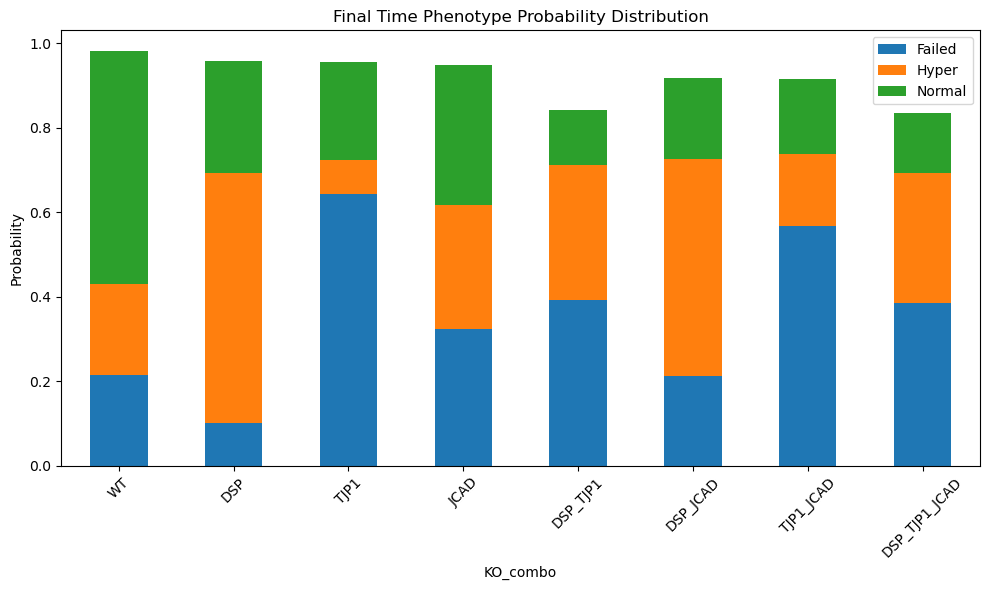

In [32]:
perbs_df.plot(x='cond', 
              y=['Failed', 'Hyper', 'Normal'],
              kind='bar',
              stacked=True,
              figsize=(10,6))

plt.xlabel('KO_combo') 
plt.ylabel('Probability')  
plt.title('Final Time Phenotype Probability Distribution')

plt.xticks(rotation=45)  # Rotate labels if needed
plt.savefig(os.path.join(summary_dir, "KO_summary_plot.png"))
plt.tight_layout()
plt.show()


In [24]:
perbs_df

,Failed,Hyper,Normal
cond,,,
WT,0.214747,0.216340,0.550629
DSP,0.102066,0.590611,0.265460
TJP1,0.643845,0.080712,0.230637
JCAD,0.324095,0.292478,0.331004
DSP_TJP1,0.393385,0.319766,0.130051
DSP_JCAD,0.213526,0.511693,0.193281
TJP1_JCAD,0.566705,0.171942,0.177850
DSP_TJP1_JCAD,0.385378,0.306790,0.143772


In [ ]:

# perbs_df.plot(kind="bar", stacked=True, figsize=(10,5), title="Final Phenotype Probabilities")
# plt.ylabel("Probability")
# plt.xticks(rotation=45)
# plt.tight_layout()